### 테슬라 주식과 엔비디아 주식의 2024년 한 해 동안의 종가 데이터를 다운로드 받아 보아라.

In [30]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

tickers=['TSLA','NVDA']

# 기간 지정
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-12-31', '%Y-%m-%d')


result_df = pd.DataFrame()

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'
    # 칼럼 이름 변경
    df.columns = [ticker]

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,TSLA,NVDA
Date,,
2024-01-02 00:00:00-05:00,248.419998,48.143856
2024-01-03 00:00:00-05:00,238.449997,47.545158
2024-01-04 00:00:00-05:00,237.929993,47.973946
2024-01-05 00:00:00-05:00,237.490005,49.072395
2024-01-08 00:00:00-05:00,240.449997,52.226818
...,...,...
2024-12-23 00:00:00-05:00,430.600006,139.639572
2024-12-24 00:00:00-05:00,462.279999,140.189468
2024-12-26 00:00:00-05:00,454.130005,139.899521


In [31]:
# Excel Sheet으로 보기
# Colab에서는 작동하지 않음
#import xlwings as xw

#xw.view(result_df)

# pykrx

In [32]:
!pip install pykrx

In [33]:
# pip install pykrx
from pykrx import stock
from pykrx import bond
from datetime import datetime

now = datetime.now()
today_date1 = now.strftime('%Y%m%d')
start_date = '20240101'

In [34]:
# krx 종목리스트
market_list = ['KOSPI', 'KOSDAQ', 'KONEX']

kor_ticker_list_df = pd.DataFrame()
for market_nm in market_list:
    ticker_list = stock.get_market_ticker_list(today_date1, market=market_nm)
    for tickers in ticker_list:
        corp_name = stock.get_market_ticker_name(tickers)
        df = pd.DataFrame({'ticker':tickers,
                           'corp_name':corp_name,
                           'market': market_nm
                          }, index = [0])
        kor_ticker_list_df = pd.concat([kor_ticker_list_df,df])
kor_ticker_list_df = kor_ticker_list_df.reset_index(drop = True)
kor_ticker_list_df.head()

,ticker,corp_name,market
0,095570,AJ네트웍스,KOSPI
1,006840,AK홀딩스,KOSPI
2,027410,BGF,KOSPI
3,282330,BGF리테일,KOSPI
4,138930,BNK금융지주,KOSPI


In [35]:
#xw.view(kor_ticker_list_df)

In [36]:
kor_ticker_list_df.tail(20)

,ticker,corp_name,market
2867,346010,타이드,KONEX
2868,318660,타임기술,KONEX
2869,476710,타조이엔터테인먼트,KONEX
2870,434190,탈로스,KONEX
2871,180060,탑선,KONEX
2872,052960,태양3C,KONEX
2873,116100,태양기계,KONEX
2874,308700,테크엔,KONEX
2875,258050,테크트랜스,KONEX
2876,413300,티엘엔지니어링,KONEX


In [37]:
kor_ticker_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2887 entries, 0 to 2886
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ticker     2887 non-null   object
 1   corp_name  2887 non-null   object
 2   market     2887 non-null   object
dtypes: object(3)
memory usage: 67.8+ KB


### 현대차 주식과 KG모빌리언스 주식의 2024년 한 해 동안의 종가 데이터를 다운로드 받아 보아라.

In [38]:
stock.get_market_ohlcv(start_date, end_date, '005380')

,시가,고가,저가,종가,거래량,등락률
날짜,,,,,,
2024-01-02,202000,202500,199800,200500,373050,-1.474201
2024-01-03,199100,199500,193800,193800,548675,-3.341646
2024-01-04,192000,192800,189100,190000,505979,-1.960784
2024-01-05,190100,190500,187200,187300,440219,-1.421053
2024-01-08,187600,188900,185500,185700,323498,-0.854245
...,...,...,...,...,...,...
2024-12-23,212500,216500,212000,215000,468339,2.137767
2024-12-24,215000,217000,213000,216500,351647,0.697674
2024-12-26,217500,219500,215000,217500,460871,0.461894


In [39]:
# 현대차 티커: 005380, KG모빌리언스 티커: 046440

tickers=['005380','046440']
# 기간 지정
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-12-31', '%Y-%m-%d')

result_df = pd.DataFrame()

for ticker in tickers:
    data = stock.get_market_ohlcv(start_date, end_date, ticker)
    df=pd.DataFrame(data['종가'])

    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'

    # 칼럼 이름 변경
    df.columns = [ticker]

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,005380,046440
Date,,
2024-01-02,200500,5360
2024-01-03,193800,5430
2024-01-04,190000,5320
2024-01-05,187300,5270
2024-01-08,185700,5310
...,...,...
2024-12-23,215000,4870
2024-12-24,216500,4860
2024-12-26,217500,4880


### 테슬라 주식과 엔비디아 주식의 2024년 한 해 동안의 종가 데이터를 다운로드 받은 후, 각 데이터를 첫 날 데이터로 표준화하여 chart로 그려보아라.

In [40]:
result_df = pd.DataFrame()

tickers=['TSLA','NVDA']

# 기간 지정
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-12-31', '%Y-%m-%d')

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    # 기준일의 종가(값이 없을 시 직전 영업일 값으로)
    ref_price = df['Close'].iloc[0]
    # 정규화하여 수정주가 칼럼 추가
    df['Adjusted_Close'] = (df['Close'] / ref_price) * 100
    # 칼럼 이름 변경
    df.columns = [ticker,ticker+'_adj']

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,TSLA,TSLA_adj,NVDA,NVDA_adj
Date,,,,
2024-01-02 00:00:00-05:00,248.419998,100.000000,48.143856,100.000000
2024-01-03 00:00:00-05:00,238.449997,95.986635,47.545158,98.756440
2024-01-04 00:00:00-05:00,237.929993,95.777310,47.973946,99.647078
2024-01-05 00:00:00-05:00,237.490005,95.600196,49.072395,101.928677
2024-01-08 00:00:00-05:00,240.449997,96.791723,52.226818,108.480754
...,...,...,...,...
2024-12-23 00:00:00-05:00,430.600006,173.335484,139.639572,290.046506
2024-12-24 00:00:00-05:00,462.279999,186.088078,140.189468,291.188700
2024-12-26 00:00:00-05:00,454.130005,182.807346,139.899521,290.586447


<Axes: xlabel='Date'>

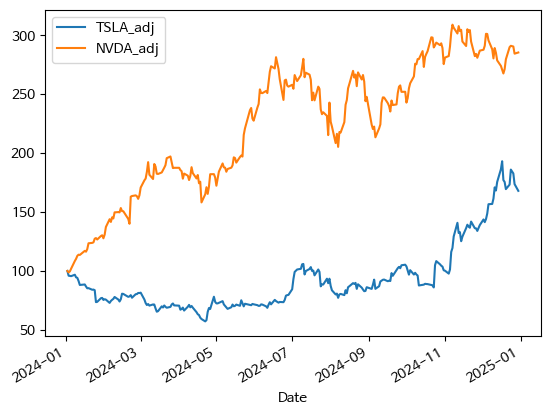

In [41]:
# chart로 그리기
result_df.loc['2024-01':'2024-12',['TSLA_adj','NVDA_adj']].plot()

In [42]:
# 이동평균(Moving Average) 구하기
result_df['TSLA_MA']=result_df.TSLA.rolling(5).mean() # 5개씩 이동평균을 만든다.
result_df['NVDA_MA']=result_df.NVDA.rolling(5).mean() # 5개씩 이동평균을 만든다.
result_df.head(10) # 앞 10개 데이터추출

,TSLA,TSLA_adj,NVDA,NVDA_adj,TSLA_MA,NVDA_MA
Date,,,,,,
2024-01-02 00:00:00-05:00,248.419998,100.000000,48.143856,100.000000,NaN,NaN
2024-01-03 00:00:00-05:00,238.449997,95.986635,47.545158,98.756440,NaN,NaN
2024-01-04 00:00:00-05:00,237.929993,95.777310,47.973946,99.647078,NaN,NaN
2024-01-05 00:00:00-05:00,237.490005,95.600196,49.072395,101.928677,NaN,NaN
2024-01-08 00:00:00-05:00,240.449997,96.791723,52.226818,108.480754,240.547998,48.992435
2024-01-09 00:00:00-05:00,234.960007,94.581760,53.113373,110.322224,237.856000,49.986338
2024-01-10 00:00:00-05:00,233.940002,94.171163,54.322765,112.834263,236.954001,51.341859
2024-01-11 00:00:00-05:00,227.220001,91.466067,54.794525,113.814160,234.812003,52.705975
2024-01-12 00:00:00-05:00,218.889999,88.112874,54.682575,113.581627,231.092001,53.828011


<Axes: xlabel='Date'>

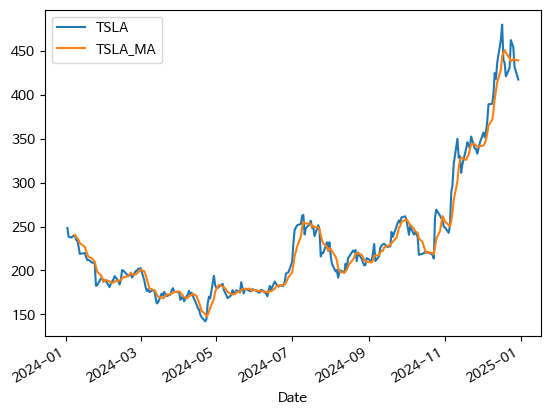

In [43]:
# chart로 그리기
result_df.loc['2024-01':'2024-12',['TSLA','TSLA_MA']].plot()

In [44]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2024-01-02 00:00:00-05:00 to 2024-12-30 00:00:00-05:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TSLA      251 non-null    float64
 1   TSLA_adj  251 non-null    float64
 2   NVDA      251 non-null    float64
 3   NVDA_adj  251 non-null    float64
 4   TSLA_MA   247 non-null    float64
 5   NVDA_MA   247 non-null    float64
dtypes: float64(6)
memory usage: 21.8 KB


In [45]:
# 월간 데이터 추출

TSLA_ohlc=result_df['TSLA'].resample('ME').ohlc()
TSLA_ohlc

,open,high,low,close
Date,,,,
2024-01-31 00:00:00-05:00,248.419998,248.419998,182.630005,187.289993
2024-02-29 00:00:00-05:00,188.860001,202.039993,181.059998,201.880005
2024-03-31 00:00:00-04:00,202.639999,202.639999,162.500000,175.789993
2024-04-30 00:00:00-04:00,175.220001,194.050003,142.050003,183.279999
2024-05-31 00:00:00-04:00,179.990005,186.600006,168.470001,178.080002
2024-06-30 00:00:00-04:00,176.289993,197.880005,170.660004,197.880005
2024-07-31 00:00:00-04:00,209.860001,263.260010,209.860001,232.070007
2024-08-31 00:00:00-04:00,216.860001,223.270004,191.759995,214.110001
2024-09-30 00:00:00-04:00,210.600006,261.630005,210.600006,261.630005


In [46]:
# 분기 데이터 추출

TSLA_Quaterly=result_df['TSLA'].resample('QE').ohlc()
TSLA_Quaterly

,open,high,low,close
Date,,,,
2024-03-31 00:00:00-04:00,248.419998,248.419998,162.500000,175.789993
2024-06-30 00:00:00-04:00,175.220001,197.880005,142.050003,197.880005
2024-09-30 00:00:00-04:00,209.860001,263.260010,191.759995,261.630005
2024-12-31 00:00:00-05:00,258.019989,479.859985,213.649994,417.410004


### 테슬라 주식과 엔비디아 주식의 2024년 한 해 동안의 종가 데이터를 다운로드 받은 후, 각 주가에 대한 로그리턴 데이터 칼럼을 생성해 보아라.

In [47]:
import numpy as np

result_df = pd.DataFrame()

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    # 기준일의 종가(값이 없을 시 직전 영업일 값으로)
    ref_price = df['Close'].iloc[0]
    # 로그 리턴 데이터 생상
    df['Return']=np.log(df['Close'])-np.log(df['Close'].shift(1))
    # 칼럼 이름 변경
    df.columns = [ticker,ticker+'_return']

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,TSLA,TSLA_return,NVDA,NVDA_return
Date,,,,
2024-01-02 00:00:00-05:00,248.419998,NaN,48.143856,NaN
2024-01-03 00:00:00-05:00,238.449997,-0.040961,47.545158,-0.012514
2024-01-04 00:00:00-05:00,237.929993,-0.002183,47.973946,0.008978
2024-01-05 00:00:00-05:00,237.490005,-0.001851,49.072395,0.022639
2024-01-08 00:00:00-05:00,240.449997,0.012387,52.226818,0.062299
...,...,...,...,...
2024-12-23 00:00:00-05:00,430.600006,0.022404,139.639572,0.036232
2024-12-24 00:00:00-05:00,462.279999,0.070991,140.189468,0.003930
2024-12-26 00:00:00-05:00,454.130005,-0.017787,139.899521,-0.002070


### 테슬라 주식의 2024년 한 해 동안의 daily 수익율 데이터 칼럼을 바탕으로 수익율의 평균, 분산, 표준편차를 구하고 이를 연간데이터로 환산해 보아라.

In [48]:
import numpy as np

Daily_return=result_df.TSLA_return

# Daily 수익율의 평균, 분산, 표준편차
Daily_mean=np.mean(Daily_return)*100
Daily_var=np.var(Daily_return)
Daily_std=np.std(Daily_return)

print('Daily mean:{:.4f}%'.format(Daily_mean))
print('Daily variance:{:.4f}'.format(Daily_var))
print('Daily standard deviation:{:.4f}'.format(Daily_std))

Daily mean:0.2076%
Daily variance:0.0016
Daily standard deviation:0.0394


In [49]:
# Monthly return
TSLA_monthly=result_df['TSLA'].resample('ME').ohlc()[['close']]
# 로그 리턴 데이터 생상
TSLA_monthly['Return']=np.log(TSLA_monthly['close'])-np.log(TSLA_monthly['close'].shift(1))

# Monthy 수익율의 평균, 분산, 표준편차
print('Monthly mean:{:.4f}%'.format(np.mean(TSLA_monthly.Return)*100))
print('Monthly variance:{:.4f}'.format(np.var(TSLA_monthly.Return)))
print('Monthly standard deviation:{:.4f}'.format(np.std(TSLA_monthly.Return)))

Monthly mean:7.2856%
Monthly variance:0.0177
Monthly standard deviation:0.1331


In [50]:
# Monthy 수익율의 평균, 분산, 표준편차 추정
print('Monthly mean:{:.4f}%'.format(Daily_mean*20))
print('Monthly variance:{:.4f}'.format(Daily_var*20))
print('Monthly standard deviation:{:.4f}'.format(Daily_std*np.sqrt(20)))

Monthly mean:4.1516%
Monthly variance:0.0310
Monthly standard deviation:0.1761


In [51]:
# Annual 수익율의 평균, 분산, 표준편차 추정
print('Annual mean:{:.4f}%'.format(Daily_mean*252))
print('Annual variance:{:.4f}'.format(Daily_var*252))
print('Annual standard deviation:{:.4f}'.format(Daily_std*np.sqrt(252)))

Annual mean:52.3100%
Annual variance:0.3909
Annual standard deviation:0.6252


In [52]:
result_df = pd.DataFrame()

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    # 기준일의 종가(값이 없을 시 직전 영업일 값으로)
    ref_price = df['Close'].iloc[0]
    # 로그 리턴 데이터 생상
    df['Return']=np.log(df['Close'])-np.log(df['Close'].shift(1))

    # 변동성(volatility) 데이터 생성
    df['Volatility_6M'] = df['Return'].rolling(window=126).std() * np.sqrt(252)
    # 칼럼 이름 변경
    df.columns = [ticker,ticker+'_return',ticker+'_6MVol']

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,TSLA,TSLA_return,TSLA_6MVol,NVDA,NVDA_return,NVDA_6MVol
Date,,,,,,
2024-01-02 00:00:00-05:00,248.419998,NaN,NaN,48.143856,NaN,NaN
2024-01-03 00:00:00-05:00,238.449997,-0.040961,NaN,47.545158,-0.012514,NaN
2024-01-04 00:00:00-05:00,237.929993,-0.002183,NaN,47.973946,0.008978,NaN
2024-01-05 00:00:00-05:00,237.490005,-0.001851,NaN,49.072395,0.022639,NaN
2024-01-08 00:00:00-05:00,240.449997,0.012387,NaN,52.226818,0.062299,NaN
...,...,...,...,...,...,...
2024-12-23 00:00:00-05:00,430.600006,0.022404,0.699054,139.639572,0.036232,0.525509
2024-12-24 00:00:00-05:00,462.279999,0.070991,0.702660,140.189468,0.003930,0.525522
2024-12-26 00:00:00-05:00,454.130005,-0.017787,0.703518,139.899521,-0.002070,0.524760


### 테슬라 주식과 엔비디아 주식의 2024년 한 해 동안의 종가 기준 로그리턴 데이터 칼럼을 만든 후, 6개월 상관계수 데이터를 만들어 보아라.

In [53]:
result_df = pd.DataFrame()

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    # 기준일의 종가(값이 없을 시 직전 영업일 값으로)
    ref_price = df['Close'].iloc[0]
    # 로그 리턴 데이터 생상
    df['Return']=np.log(df['Close'])-np.log(df['Close'].shift(1))
    # 칼럼 이름 변경
    df.columns = [ticker,ticker+'_return']

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)

# 6개월 상관계수 만들기
result_df['TSLA_NVDA_corr'] = (
    result_df['TSLA_return']
    .rolling(126)
    .corr(result_df['NVDA_return'])
)

result_df

,TSLA,TSLA_return,NVDA,NVDA_return,TSLA_NVDA_corr
Date,,,,,
2024-01-02 00:00:00-05:00,248.419998,NaN,48.143856,NaN,NaN
2024-01-03 00:00:00-05:00,238.449997,-0.040961,47.545158,-0.012514,NaN
2024-01-04 00:00:00-05:00,237.929993,-0.002183,47.973946,0.008978,NaN
2024-01-05 00:00:00-05:00,237.490005,-0.001851,49.072395,0.022639,NaN
2024-01-08 00:00:00-05:00,240.449997,0.012387,52.226818,0.062299,NaN
...,...,...,...,...,...
2024-12-23 00:00:00-05:00,430.600006,0.022404,139.639572,0.036232,0.390901
2024-12-24 00:00:00-05:00,462.279999,0.070991,140.189468,0.003930,0.389617
2024-12-26 00:00:00-05:00,454.130005,-0.017787,139.899521,-0.002070,0.389953


In [54]:
# 특정 시점에서 상관계수 행렬 출력하기
window = 126
returns = result_df[[c for c in result_df.columns if c.endswith('_return')]]

rolling_corrs = returns.rolling(window).corr()

# 특정 시점의 상관행렬 예시
print(rolling_corrs.loc['2024-12-30'])

             TSLA_return  NVDA_return
TSLA_return     1.000000     0.392366
NVDA_return     0.392366     1.000000
